# Generate Data with TimeGANs

## Content
1. [Settings and Imports](#Settings-and-Imports)
2. [Read Sample Data](#Read-Sample-Data)
3. [Train TimeGAN](#Train-TimeGAN)
4. [Generate and Prepare Data](#Generate-and-Prepare-Data)
5. [Export for Hackathon](#Export-for-Hackathon)

## Settings and Imports

In [1]:
# Print out every value 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ydata_synthetic.synthesizers.timeseries import TimeGAN 

import math
import random

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from os import path
from datetime import date, timedelta
import datetime
from dateutil.relativedelta import relativedelta

## Read Sample Data

Training the TimeGAN requires some kind of input timeseries. For this, a kaggle dataset is used.  
Download: 'https://www.kaggle.com/rohitsahoo/sales-forecasting'

In [3]:
csv_path='./train.csv'
train_df = pd.read_csv(csv_path)

#remove column RowID since pandas manages the index number
train_df = train_df.drop(columns=['Row ID'])

#convert Order Date and Ship Date to dtype datetime
train_df['Order Date'] = pd.to_datetime(train_df["Order Date"])
train_df['Ship Date'] = pd.to_datetime(train_df["Order Date"])

#sort the dataframe by order date
train_df = train_df.set_index('Order Date').sort_index()

<AxesSubplot:xlabel='Order Date'>

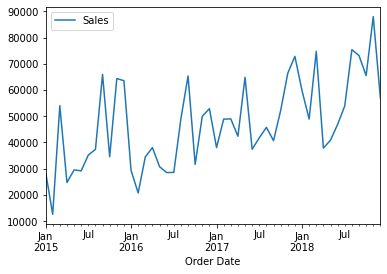

In [4]:
#check if the data seems like real data with some kind of pattern
original_df = train_df.resample('M').sum().drop(columns=['Postal Code'])
original_df.plot()

In [5]:
#All values in the Column Country are the same, so we remove that
train_df = train_df.drop(columns=['Country','Region'])

#Each customer has a unique customer id, so we can merge the two columns
train_df['Customer']= train_df['Customer Name'] + ' : ' + train_df['Customer ID']
train_df = train_df.drop(columns=['Customer Name','Customer ID'])

#Product ID and Product Name belong also together
train_df['Product']= train_df['Product Name'] + ' : ' + train_df['Product ID']
train_df = train_df.drop(columns=['Product Name','Product ID'])

#Map each value to a number for further training
#train_df['Order ID'] = len(train_df) - pd.Categorical(train_df['Order ID']).codes

train_df = train_df.drop(columns=['Order ID','Ship Date','Sub-Category','Postal Code','State','Segment'])

In [6]:
columns_map_names = ['Ship Mode', 'City', 'Product','Category','Customer']

for name in columns_map_names:
    train_df[name] = pd.Categorical(train_df[name]).codes

In [7]:
train_df['City'].nunique()

529

In [8]:
train_df.head()
train_df.dtypes

Ship Mode  City  Category    Sales  Customer  Product
Order Date                                                       
2015-01-02          0   177         2  468.900        99      609
2015-01-03          3   327         2    5.940       316     1429
2015-01-03          2   450         0  457.568       202      752
2015-01-03          3   139         1   17.472       778      342
2015-01-03          3   137         0   63.552       690      481

Ship Mode       int8
City           int16
Category        int8
Sales        float64
Customer       int16
Product        int16
dtype: object

In [9]:
train_df.tail()

Ship Mode  City  Category    Sales  Customer  Product
Order Date                                                       
2018-12-30          3   327         1   52.776       589     1682
2018-12-30          3    94         1  209.300       160      621
2018-12-30          3   327         2   90.930       589      740
2018-12-30          3   327         0  323.136       589      391
2018-12-30          3   147         1   20.720       263      687

In [10]:
print(  (len(train_df)) / (365*4)  )

6.712328767123288


In [11]:
train_df.loc[train_df['Product'] == 3]

Ship Mode  City  Category    Sales  Customer  Product
Order Date                                                       
2015-09-21          3   436         1   78.350       331        3
2015-11-16          3    41         1   78.350       714        3
2016-09-28          3    24         1   12.536       791        3
2017-01-31          3    21         1  125.360        77        3
2018-03-24          0   327         1   47.010       320        3
2018-06-22          0   293         1   37.608       188        3

In [12]:
def prep_data(data, seq_len):
    ori_data = data[::-1]
    
    print(type(ori_data))
    print(len(ori_data))
    print(ori_data[0])
    
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)
    
    temp_data = []
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)
        
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data,scaler

In [13]:
test_df,scaler = prep_data(train_df.values,24)

<class 'numpy.ndarray'>
9800
[  3.   147.     1.    20.72 263.   687.  ]


## Train TimeGAN

In [14]:
#Hyperparameters of the model

#Specific to TimeGANs
seq_len=24
n_seq = 6
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = [batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim]

### Training the TimeGAN synthetizer

In [15]:
model_path = 'synthesizer.pkl'
if path.exists(model_path):
    synth = TimeGAN.load(model_path)
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(test_df, train_steps=50000)
    synth.save(model_path)

## Generate and Prepare Data

In [16]:
synth_data = synth.sample(len(test_df))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 77/77 [00:24<00:00,  3.19it/s]

(9856, 24, 6)


In [17]:
"""#Reshaping the data
cols = ['Ship Mode', 'City', 'Category', 'Sales', 'Customer', 'Product']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(test_df))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': test_df[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()"""

"#Reshaping the data\ncols = ['Ship Mode', 'City', 'Category', 'Sales', 'Customer', 'Product']\n\n#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]\nfig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))\naxes=axes.flatten()\n\ntime = list(range(1,25))\nobs = np.random.randint(len(test_df))\n\nfor j, col in enumerate(cols):\n    df = pd.DataFrame({'Real': test_df[obs][:, j],\n                   'Synthetic': synth_data[obs][:, j]})\n    df.plot(ax=axes[j],\n            title = col,\n            secondary_y='Synthetic data', style=['-', '--'])\nfig.tight_layout()"

In [18]:
def convert_3d_to_2d(array):
    return np.reshape(array, (array.shape[0]*array.shape[1], array.shape[2] ))

synth_data = convert_3d_to_2d(synth_data)
print(synth_data.shape)

(236544, 6)


In [19]:
date_list = []
for i,_ in train_df.iterrows():
    date_list.append(i + relativedelta(years = 1))

In [20]:
new_df = []
for i,line in enumerate(date_list):
    new_element = synth_data[i].tolist()
    new_element.append(line)
    new_df.append(new_element)

In [21]:
df_columns = ['Ship Mode', 'City', 'Category', 'Sales', 'Customer', 'Product','bestelldatum']
hackathon_df = pd.DataFrame(new_df,columns=df_columns)
hackathon_df = hackathon_df.set_index('bestelldatum').sort_index()
print(hackathon_df.dtypes)

Ship Mode    float64
City         float64
Category     float64
Sales        float64
Customer     float64
Product      float64
dtype: object


In [22]:
hackathon_df.head()

Ship Mode      City  Category         Sales  Customer   Product
bestelldatum                                                                 
2016-01-02     0.999492  0.215615  0.528202  6.830509e-09  0.956295  0.373335
2016-01-03     0.999856  0.360663  0.487690  1.891840e-09  0.424738  0.943376
2016-01-03     0.999859  0.298284  0.503373  3.433541e-09  0.194494  0.162494
2016-01-03     0.999851  0.620743  0.485640  1.849641e-09  0.401664  0.715202
2016-01-03     0.628487  0.847471  0.532243  2.760839e-09  0.992518  0.511034

<AxesSubplot:xlabel='bestelldatum'>

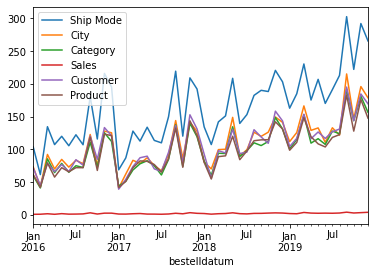

In [23]:
#check if the data seems like real data with some kind of pattern
hackathon_df.resample('M').sum().plot()

In [24]:
def convert_3d_to_2d(array):
    return np.reshape(array, (array.shape[0]*array.shape[1], array.shape[2] ))

In [25]:
#Map Shipping
shipping_map= {
    0. : 'Premiumversand',
    1. : 'Expressversand',
    2. : 'Standardversand',
    3. : 'Premiumversand'
    
}
hackathon_df['Ship Mode'] = np.floor( hackathon_df['Ship Mode'] * 3)
hackathon_df['Versandart'] = [shipping_map.get(key,'Standardversand basic') for key in hackathon_df['Ship Mode']]

In [26]:
#Map Cities
hackathon_df['City'] = np.floor( hackathon_df['City'] * 50)
converter = {'Postleitzahl':str}
city_df = pd.read_excel('cities.xlsx',converters=converter)

count = hackathon_df['City'].value_counts()
mapping = []
for i, value in city_df.iterrows():
    try:
        mapping.append(count.index[i])
    except IndexError:
        mapping.append(10000.0)

city_df['City'] = mapping 
city_df.head()

hackathon_df = hackathon_df.reset_index().merge(city_df, how='left' ,on='City').set_index('bestelldatum')

Stadt Postleitzahl  City
0                  Berlin, Stadt        10178  41.0
1  Hamburg, Freie und Hansestadt        20038  38.0
2      München, Landeshauptstadt        80313  36.0
3                    Köln, Stadt        50667  40.0
4       Frankfurt am Main, Stadt        60311  30.0

In [27]:
#Map Customer Number
hackathon_df['Customer'] = np.floor( hackathon_df['Customer'] * 400)
hackathon_df['Kundennummer'] =  [ "KND-{0:04.0f}".format(customer) for customer in hackathon_df['Customer']]

In [28]:
#Map Product Number
hackathon_df['Product'] = np.floor( hackathon_df['Product'] * 500)
hackathon_df['Produkt'] =  [ "PRK-{0:04.0f}".format(customer) for customer in hackathon_df['Product']]

In [29]:
#drop duplicate columns
hackathon_df = hackathon_df.drop(columns=['City','Ship Mode','Customer','Product','Category'])

In [30]:
#this method also scales by 2
def rev_min_max_func(scaled_val):
    max_val = max(train_df['Sales'])
    min_val = min(train_df['Sales'])
    og_val = (scaled_val * (max_val - min_val)) + min_val
    return round(og_val,3)

hackathon_df['Umsatz'] = hackathon_df['Sales'].apply(lambda x: rev_min_max_func(x))

In [31]:
max(hackathon_df['Umsatz'])
min(hackathon_df['Umsatz'])

10945.159

0.444

In [32]:
hackathon_df = hackathon_df.drop(columns=['Sales'])

In [33]:
def randomize_small_sales(sale):
    if sale >= 2:
        return sale
    else:
        return round( random.uniform(0.5, 10.0) , 3)
    
hackathon_df['Umsatz'] = hackathon_df['Umsatz'].apply(lambda x : randomize_small_sales(x))

<AxesSubplot:xlabel='Order Date'>

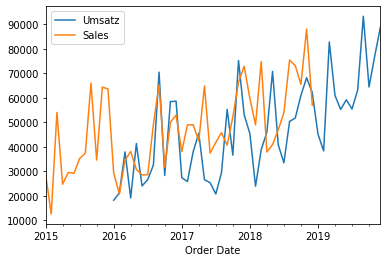

In [34]:
ax = hackathon_df.resample('M').sum().plot()
original_df.plot(ax=ax)

In [35]:
hackathon_df.columns= hackathon_df.columns.str.lower()
hackathon_df.head()

versandart                        stadt postleitzahl  \
bestelldatum                                                              
2016-01-02    Standardversand               Dresden, Stadt         1067   
2016-01-03    Standardversand             Karlsruhe, Stadt        76124   
2016-01-03    Standardversand  Wiesbaden, Landeshauptstadt        65183   
2016-01-03    Standardversand                     Augsburg        86150   
2016-01-03     Expressversand               Leipzig, Stadt         4109   

             kundennummer   produkt  umsatz  
bestelldatum                                 
2016-01-02       KND-0382  PRK-0186   3.233  
2016-01-03       KND-0169  PRK-0471   4.549  
2016-01-03       KND-0077  PRK-0081   9.696  
2016-01-03       KND-0160  PRK-0357   5.485  
2016-01-03       KND-0397  PRK-0255   6.779

In [36]:
hackathon_df['kundennummer'].value_counts()
hackathon_df.groupby('kundennummer').count()

KND-0399    84
KND-0398    63
KND-0397    57
KND-0272    42
KND-0392    40
            ..
KND-0009    12
KND-0179    11
KND-0053    11
KND-0000    10
KND-0002     8
Name: kundennummer, Length: 400, dtype: int64

versandart  stadt  postleitzahl  produkt  umsatz
kundennummer                                                  
KND-0000              10     10            10       10      10
KND-0001              20     20            20       20      20
KND-0002               8      8             8        8       8
KND-0003              27     27            27       27      27
KND-0004              15     15            15       15      15
...                  ...    ...           ...      ...     ...
KND-0395              40     40            40       40      40
KND-0396              24     24            24       24      24
KND-0397              57     57            57       57      57
KND-0398              63     63            63       63      63
KND-0399              84     84            84       84      84

[400 rows x 5 columns]

PRK-0070    36
PRK-0026    34
PRK-0357    34
PRK-0082    34
PRK-0063    32
            ..
PRK-0424    11
PRK-0001    10
PRK-0211     9
PRK-0306     9
PRK-0498     9
Name: produkt, Length: 498, dtype: int64

<AxesSubplot:xlabel='produkt'>

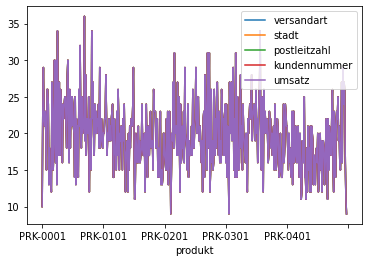

In [37]:
hackathon_df['produkt'].value_counts()
hackathon_df.groupby('produkt').count().plot()

We choose some random customer, which have regularly spendings.  

In [38]:
end_date = datetime.date(2019,12,31)
def get_dates(start_date,period):
    global end_date
    dates = []
    num_months = 1
    
    if period == 'year':
        num_months = 12
    elif period == 'half':
        num_months = 6
    elif period == 'quarter':
        num_months = 3
    elif period =='biweekly':
        return get_dates_biweekly(start_date)

    
    while start_date <= end_date:
        dates.append(start_date)
        start_date = start_date + relativedelta(months = num_months)
        
    return dates

def get_dates_biweekly(start_date,day_diff = 14):
    global end_date
    dates = []
    while start_date < end_date:
        dates.append(start_date)
        start_date = start_date + timedelta(days=day_diff)
    return dates

In [39]:
test_date = datetime.date(2016,1,1)
get_dates(test_date, 'year')

[datetime.date(2016, 1, 1),
 datetime.date(2017, 1, 1),
 datetime.date(2018, 1, 1),
 datetime.date(2019, 1, 1)]

In [40]:
def increase_sales(sales,counter, period):
    #increase sales with an increasing value
    if period == 'year':
        return sales * 1.05
    elif period == 'half':
        return sales * 1.1 if counter % 2 == 0 else sales
    elif period == 'quarter':
        return sales * 1.15 if counter % 4 == 0 else sales
    elif period == 'monthly':
        return sales * 1.2 if counter % 12 == 0 else sales
    return sales 
    
    
def add_regularly_spending(start,period,customer,sales,product = 'PRK-0000',stadt= 'Berlin, Stadt',plz = '10178'):
    dates = get_dates(start,period)
    #count is used to calculate an increase in payments every year after start
    count = 1
    for date in dates:
        regularly_spendings.append({'bestelldatum': vary_date(date), 'produkt':product,
                                    'stadt':stadt, 'postleitzahl':plz,
                                    'kundennummer':customer,'umsatz':vary_sales(sales),
                                    'versandart':'Premiumversand'})
        sales = increase_sales(sales,count,period)
        count += 1
        
def vary_sales(sales):
    return sales + random.uniform(0.9, 1.1)

def vary_date(date):
    move_by_days = random.randint(-2,2)
    #Check that date doesn't move out of the dataset into the year 2014 or 2019
    new_date = date + timedelta(days = move_by_days)
    return new_date if datetime.date(2015,12,31) < new_date < datetime.date(2020,1,1) else date

In [41]:
city_df.head(30)

Stadt Postleitzahl  City
0                   Berlin, Stadt        10178  41.0
1   Hamburg, Freie und Hansestadt        20038  38.0
2       München, Landeshauptstadt        80313  36.0
3                     Köln, Stadt        50667  40.0
4        Frankfurt am Main, Stadt        60311  30.0
5     Stuttgart, Landeshauptstadt        70173  39.0
6               Düsseldorf, Stadt        40213  33.0
7                  Leipzig, Stadt         4109  42.0
8                 Dortmund, Stadt        44135  37.0
9                    Essen, Stadt        45127  35.0
10                  Bremen, Stadt        28195  34.0
11                 Dresden, Stadt         1067  10.0
12     Hannover, Landeshauptstadt        30159  25.0
13                       Nürnberg        90403  12.0
14                Duisburg, Stadt        47051  43.0
15                  Bochum, Stadt        44787  29.0
16               Wuppertal, Stadt        42275  19.0
17               Bielefeld, Stadt        33597  28.0
18                    Bonn, Stadt        53111  11.0
19                 Münster, Stadt        48127  26.0
20               Karlsruhe, Stadt        76124  18.0
21    Mannheim, Universitätsstadt        68159  32.0
22                       Augsburg        86150  31.0
23    Wiesbaden, Landeshauptstadt        65183  14.0
24         Mönchengladbach, Stadt        41061  16.0
25           Gelsenkirchen, Stadt        45879  15.0
26            Braunschweig, Stadt        38100  45.0
27                  Aachen, Stadt        52062  13.0
28         Kiel, Landeshauptstadt        24103  27.0
29                Chemnitz, Stadt         9111  47.0

In [42]:
regularly_spendings = []
#add biweekly spendings
add_regularly_spending( start = datetime.date(2016,1,5) , period = 'biweekly',
                       customer = 'KND-0210',sales =  800.0, product = 'PRK-0411',
                       stadt = 'Berlin, Stadt', plz = '10178')

add_regularly_spending( start = datetime.date(2017,1,6) , period = 'biweekly',
                       customer = 'KND-0028',sales =  600.0, product = 'PRK-0028',
                       stadt = 'Hannover, Landeshauptstadt', plz = '30519')

add_regularly_spending( start = datetime.date(2016,1,5) , period = 'biweekly',
                       customer = 'KND-0358',sales =  800.0, product = 'PRK-0138',
                       stadt = 'Karlsruhe, Stadt', plz = '76124')

add_regularly_spending( start = datetime.date(2016,7,13) , period = 'biweekly',
                       customer = 'KND-0258',sales =  900.0, product = 'PRK-0316',
                       stadt = 'Münster, Stadt', plz = '48127')

add_regularly_spending( start = datetime.date(2016,2,9) , period = 'biweekly',
                       customer = 'KND-0110',sales =  475.0, product = 'PRK-0321',
                       stadt = 'Augsburg', plz = '86150')

add_regularly_spending( start = datetime.date(2016,1,14) , period = 'biweekly',
                       customer = 'KND-0213',sales =  450.0, product = 'PRK-0028',
                       stadt = 'Kiel, Landeshauptstadt', plz = '24103')

add_regularly_spending( start = datetime.date(2016,1,5) , period = 'biweekly',
                       customer = 'KND-0221',sales =  670.0, product = 'PRK-0124',
                       stadt = 'Gelsenkirchen, Stadt', plz = '45879')

add_regularly_spending( start = datetime.date(2016,7,13) , period = 'biweekly',
                       customer = 'KND-0258',sales =  550.0, product = 'PRK-0314',
                       stadt = 'Wuppertal, Stadt', plz = '42275')

add_regularly_spending( start = datetime.date(2016,1,5) , period = 'biweekly',
                       customer = 'KND-0214',sales =  660.0, product = 'PRK-0418',
                       stadt = 'Berlin, Stadt', plz = '10178')

add_regularly_spending( start = datetime.date(2017,2,6) , period = 'biweekly',
                       customer = 'KND-0083',sales =  430.0, product = 'PRK-0026',
                       stadt = 'Bonn, Stadt', plz = '53111')

add_regularly_spending( start = datetime.date(2016,3,5) , period = 'biweekly',
                       customer = 'KND-0320',sales =  330.0, product = 'PRK-0218',
                       stadt = 'Karlsruhe, Stadt', plz = '76124')

add_regularly_spending( start = datetime.date(2016,7,13) , period = 'biweekly',
                       customer = 'KND-0244',sales =  760.0, product = 'PRK-0189',
                       stadt = 'München, Landeshauptstadt', plz = '80313')

#add monthly spendings
add_regularly_spending( start = datetime.date(2016,1,1) , period = 'monthly',
                       customer = 'KND-0213',sales =  900.0, product = 'PRK-0111',
                       stadt = 'Berlin, Stadt', plz = '10178')

add_regularly_spending( start = datetime.date(2016,1,7) , period = 'monthly',
                       customer = 'KND-0164',sales =  1280.0, product = 'PRK-0222',
                       stadt = 'München, Landeshauptstadt', plz = '80313' )

add_regularly_spending( start = datetime.date(2016,1,25) , period = 'monthly',
                       customer = 'KND-0304',sales =  760.0, product = 'PRK-0333',
                       stadt = 'Frankfurt am Main, Stadt', plz = '60311')

add_regularly_spending( start = datetime.date(2017,1,1) , period = 'monthly',
                       customer = 'KND-0204',sales =  860.0, product = 'PRK-0300',
                       stadt = 'Bonn, Stadt', plz = '53111')

add_regularly_spending( start = datetime.date(2016,1,15) , period = 'monthly',
                       customer = 'KND-0304',sales =  1050.0, product = 'PRK-0311',
                       stadt = 'Bielefeld, Stadt', plz = '33597')

add_regularly_spending( start = datetime.date(2016,1,21) , period = 'monthly',
                       customer = 'KND-0304',sales =  1300.0, product = 'PRK-0022',
                       stadt = 'Frankfurt am Main, Stadt', plz = '60311')


#add quarterly spendings
add_regularly_spending( start = datetime.date(2016,1,7) , period = 'quarterly',
                       customer = 'KND-0188' ,sales =  1500.0, product = 'PRK-0300',
                       stadt = 'Berlin, Stadt', plz = '10178')

add_regularly_spending( start = datetime.date(2016,3,28) , period = 'quarterly',
                       customer = 'KND-0091' ,sales =  1750.0, product = 'PRK-0123',
                       stadt = 'Frankfurt am Main, Stadt', plz = '60311')

add_regularly_spending( start = datetime.date(2016,1,3) , period = 'quarterly',
                       customer = 'KND-0399' ,sales =  2000.0, product = 'PRK-0274',
                       stadt = 'Leipzig, Stadt', plz = '4109')

add_regularly_spending( start = datetime.date(2016,1,3) , period = 'quarterly',
                       customer = 'KND-0191' ,sales =  1800.0, product = 'PRK-0270',
                       stadt = 'Bonn, Stadt', plz = '53111')

add_regularly_spending( start = datetime.date(2016,2,3) , period = 'quarterly',
                       customer = 'KND-0299' ,sales =  4000.0, product = 'PRK-0270',
                       stadt = 'Leipzig, Stadt', plz = '4109')


#add half-yearly spendings
add_regularly_spending( start = datetime.date(2016,1,15) , period = 'half',
                       customer = 'KND-0229' ,sales =  1400.0, product = 'PRK-0100',
                       stadt = 'Dortmund, Stadt', plz = '44135')

add_regularly_spending( start = datetime.date(2017,1,5) , period = 'half',
                       customer = 'KND-0027' ,sales =  1600.0, product = 'PRK-0340',
                       stadt = 'Berlin, Stadt', plz = '10178')

add_regularly_spending( start = datetime.date(2016,2,1) , period = 'half',
                       customer = 'KND-0271' ,sales =  1880.0, product = 'PRK-0387',
                       stadt = 'Hannover, Landeshauptstadt', plz = '30159')

add_regularly_spending( start = datetime.date(2016,1,5) , period = 'half',
                       customer = 'KND-0171' ,sales =  2380.0, product = 'PRK-0187',
                       stadt = 'Berlin, Stadt', plz = '10178')


#add yearly spendings
add_regularly_spending( start = datetime.date(2016,12,30) , period = 'year',
                       customer = 'KND-0288' ,sales =  3450.0, product = 'PRK-0167',
                       stadt = 'Dresden, Stadt', plz = '1067')

add_regularly_spending( start = datetime.date(2016,6,30) , period = 'year',
                       customer = 'KND-0218' ,sales =  3300.0, product = 'PRK-0238',
                       stadt = 'Leipzig, Stadt', plz = '4109')

add_regularly_spending( start = datetime.date(2016,1,30) , period = 'year',
                       customer = 'KND-0011' ,sales =  3000.0, product = 'PRK-0049',
                       stadt = 'Dortmund, Stadt', plz = '44135')

add_regularly_spending( start = datetime.date(2016,1,7) , period = 'year',
                       customer = 'KND-0131' ,sales =  3350.0, product = 'PRK-0361',
                       stadt = 'Hannover, Landeshauptstadt', plz = '30159')

add_regularly_spending( start = datetime.date(2016,1,5) , period = 'year',
                       customer = 'KND-0138' ,sales =  2999.0, product = 'PRK-0261',
                       stadt = 'München, Landeshauptstadt', plz = '80313')

add_regularly_spending( start = datetime.date(2016,12,1) , period = 'year',
                       customer = 'KND-0399' ,sales =  4000.0, product = 'PRK-0161',
                       stadt = 'München, Landeshauptstadt', plz = '80313')

add_regularly_spending( start = datetime.date(2016,3,10) , period = 'year',
                       customer = 'KND-0199' ,sales =  3000.0, product = 'PRK-0061',
                       stadt = 'Bielefeld, Stadt', plz = '33597')

In [43]:
regularly_df = pd.DataFrame(regularly_spendings)
regularly_df['bestelldatum'] = pd.to_datetime(regularly_df['bestelldatum'])
regularly_df = regularly_df.set_index('bestelldatum').sort_index()
regularly_df.head()

produkt                      stadt postleitzahl kundennummer  \
bestelldatum                                                                  
2016-01-01    PRK-0111              Berlin, Stadt        10178     KND-0213   
2016-01-03    PRK-0418              Berlin, Stadt        10178     KND-0214   
2016-01-03    PRK-0274             Leipzig, Stadt         4109     KND-0399   
2016-01-03    PRK-0261  München, Landeshauptstadt        80313     KND-0138   
2016-01-04    PRK-0124       Gelsenkirchen, Stadt        45879     KND-0221   

                   umsatz      versandart  
bestelldatum                               
2016-01-01     901.086889  Premiumversand  
2016-01-03     660.984030  Premiumversand  
2016-01-03    2001.035769  Premiumversand  
2016-01-03    3000.078303  Premiumversand  
2016-01-04     670.993197  Premiumversand

<AxesSubplot:xlabel='bestelldatum'>

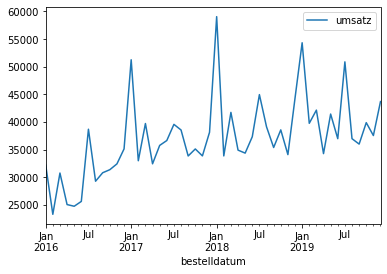

In [44]:
regularly_df.resample('M').sum().plot()

<AxesSubplot:xlabel='bestelldatum'>

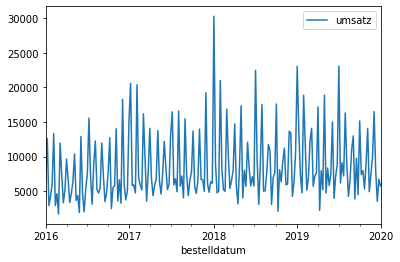

In [45]:
regularly_df.resample('W').sum().plot()

In [46]:
hackathon_df = hackathon_df.append(regularly_df).sort_index()
hackathon_df.head()

versandart                        stadt postleitzahl  \
bestelldatum                                                              
2016-01-01     Premiumversand                Berlin, Stadt        10178   
2016-01-02    Standardversand               Dresden, Stadt         1067   
2016-01-03    Standardversand  Wiesbaden, Landeshauptstadt        65183   
2016-01-03     Premiumversand                Berlin, Stadt        10178   
2016-01-03    Standardversand             Karlsruhe, Stadt        76124   

             kundennummer   produkt      umsatz  
bestelldatum                                     
2016-01-01       KND-0213  PRK-0111  901.086889  
2016-01-02       KND-0382  PRK-0186    3.233000  
2016-01-03       KND-0077  PRK-0081    9.696000  
2016-01-03       KND-0214  PRK-0418  660.984030  
2016-01-03       KND-0169  PRK-0471    4.549000

In [47]:
#round all sales to 3 decimal numbers
hackathon_df['umsatz']= hackathon_df['umsatz'].apply(lambda x: round(x))

<AxesSubplot:xlabel='Order Date'>

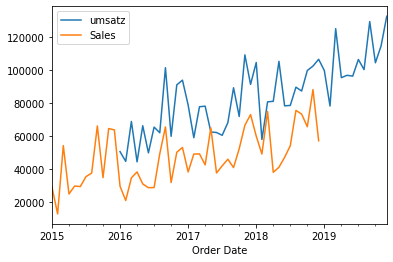

In [48]:
ax = hackathon_df.resample('M').sum().plot()
original_df.plot(ax=ax)

<AxesSubplot:xlabel='bestelldatum'>

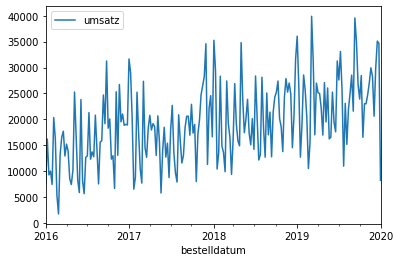

In [49]:
hackathon_df.resample('W').sum().plot()

<AxesSubplot:xlabel='bestelldatum'>

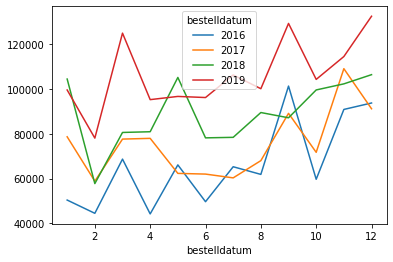

In [50]:
agg_df = hackathon_df.resample('M').sum()
pd.pivot_table(agg_df, index = agg_df.index.month, columns=agg_df.index.year,
              values='umsatz', aggfunc='sum').plot()

## Export for Hackathon

In [51]:
hackathon_df.to_csv('hackathon.csv')

In [52]:
challenge_df = hackathon_df['20160101':'20190630']
solution_df = hackathon_df['20190701':'20200101']

<AxesSubplot:xlabel='bestelldatum'>

<AxesSubplot:xlabel='bestelldatum'>

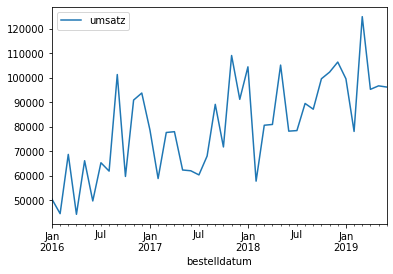

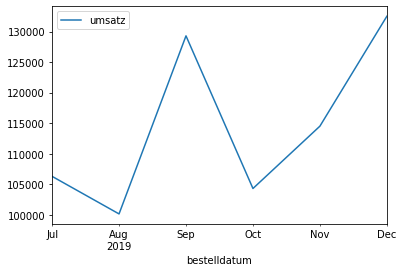

In [53]:
challenge_df.resample('M').sum().plot()
solution_df.resample('M').sum().plot()

In [54]:
#save the challenge dataframe 
challenge_df.to_csv('challenge.csv')

In [55]:
solution_df.resample('Y').sum().to_csv('solution_year.csv')
solution_df.resample('M').sum().to_csv('solution_month.csv')
solution_df.resample('W').sum().to_csv('solution_weekly.csv')